# Guided Project: Predicting Bike Rentals

## Introduction

Many cities have communal biking sharing stations where you can either rent by hour or day. This dataset we'll be working with was compiled by Hadi Fanaee-T at the University of Porto. It contains 17380 rows and each row represents the number of bike rentals for a single hour of a single day. 

**The goal of this project is to predict the number of bikes rented in a given hour.** We'll generate a few machine learning models to do so.

Here are the descriptions for the relevant columns:

- `instant` - A unique sequential ID number for each row
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred
- `yr` - The year the rentals occurred
- `mnth` - The month the rentals occurred
- `hr` - The hour the rentals occurred
- `holiday` - Whether or not the day was a holiday
- `weekday` - The day of the week (as a number, 0 to 7)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather (as a categorical variable)
- `temp` - The temperature, on a 0-1 scale
- `atemp` - The adjusted temperature
- `hum` - The humidity, on a 0-1 scale
- `windspeed` - The wind speed, on a 0-1 scale
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (casual + registered)


In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")

In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
# Overview of the distribution of values and what unique values there are
for col in bike_rentals.columns:
    print("{} COLUMN".format(col))
    print(bike_rentals[col].value_counts(dropna=False))
    print("=" * 50)

instant COLUMN
2047     1
4727     1
12947    1
14994    1
8849     1
        ..
5416     1
11551    1
9502     1
15645    1
2049     1
Name: instant, Length: 17379, dtype: int64
dteday COLUMN
2012-06-06    24
2012-10-03    24
2011-08-02    24
2011-06-20    24
2011-11-18    24
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: dteday, Length: 731, dtype: int64
season COLUMN
3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64
yr COLUMN
1    8734
0    8645
Name: yr, dtype: int64
mnth COLUMN
7     1488
5     1488
12    1483
8     1475
3     1473
10    1451
6     1440
11    1437
9     1437
4     1437
1     1429
2     1341
Name: mnth, dtype: int64
hr COLUMN
16    730
17    730
15    729
13    729
14    729
22    728
18    728
19    728
20    728
21    728
23    728
12    728
7     727
8     727
9     727
10    727
11    727
0     726
6     725
1     724
5     717
2     715
4     697
3     697
Name: hr, dtype: int64
holi

In [5]:
# Check for nulls
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
# Check dtypes
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


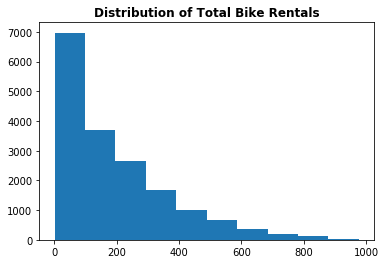

In [7]:
# Generate quick histogram of target
plt.hist(bike_rentals["cnt"])
plt.title("Distribution of Total Bike Rentals", 
          fontdict={"fontweight":"bold"})


plt.show()

# We can see that the distribution is right tailed, which is to be expected. However, something that I find 
# interesting is that there were some hours where there were 600+ bikes rented. I am curious to see which days/hours
# these were.

## Changing the `hr` column to different labels

The `hr` column represents the hours during which bikes are rented. So, instead of separating it by hour, let's separate it by `morning`, `afternoon`, `evening`, `night`.

- `morning` or `1` - if 6 to 12 (12 being exclusive)
- `afternoon` or `2` - if 12 to 18
- `evening` or `3` - if 18 to 24
- `night` or `4`- if 0 to 6

In [8]:
def apply_label(row):
    
    if row["hr"] in range(6,12):
        # morning
        return 1
    elif row["hr"] in range(12,18):
        # afternoon
        return 2
    elif row["hr"] in range(18,24):
        # evening
        return 3
    else:
        # night
        return 4
        

bike_rentals["time_label"] = bike_rentals.apply(apply_label, axis=1)

In [9]:
bike_rentals.head(25)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,4
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


## Splitting data into `train` and `test`

`train` will be 80% of our data and `test` will be 20%.

In [10]:
train = bike_rentals.sample(frac=.8, random_state=1)
test = bike_rentals.drop(train.index)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (13903, 18)
Test shape: (3476, 18)


## Linear Regression Model

Before we start implementing a machine learning algorithm, we must decide on what error metric we are going to use to evaluate the performance of our model. Since our target variable is a continuous variable, we'll use the following metrics for our linear regression model.

- **RMSE (Root mean squared error)** - Provides us the square root of the average squared differences between predicted and actual observations while penalizing larger errors.
- **R-Squared** - Represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

### Selecting the right features

To perform feature selection, we are going to look at the columns highly correlated with `cnt` (our target column).

Also, we need to make sure the columns that we select are not correlated with each other because this would add noise to our data. In this case, we'll keep the column that has a higher correlation with `cnt`. 

Let's generate a correlation heatmap to visualize this.

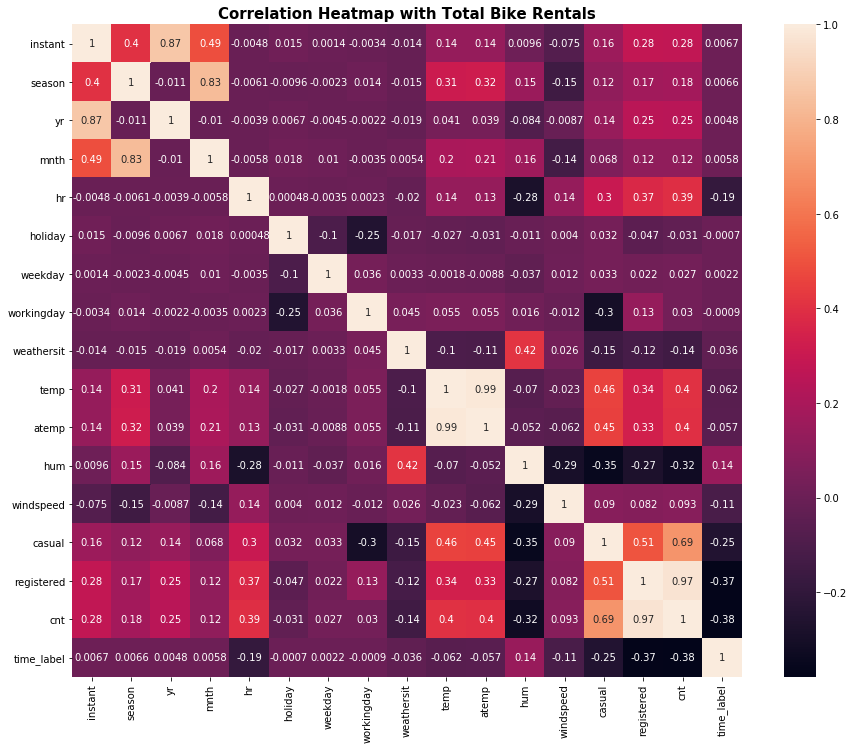

In [11]:
# Generate corr plot with `cnt`
corr = pd.DataFrame(bike_rentals.corr())

fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap with Total Bike Rentals", 
          fontdict={"fontsize":15,
                    "fontweight":"bold"})

plt.show()

# We can see that `causal` and `registered` columns are strongly positively correlated with `cnt`. 
# This is because `cnt` is just a sum of both of those columns.

### Results

Looking at the `cnt` row, we can remove `instant` because it represents an index.

We can expect `mnth`, `holiday`, `weekday`, `workingday`, `weathersit`, and `windspeed` to have little effect on our model, so we'll exclude them. 

We are also not including `casual` and `registered` because they represent future information in our model and this would cause a data leakage. 

`temp` and `atemp` are highly correlated with each other since they both represent a variation of the temperature of the day. Let's keep `temp` since it represents the actual temperature.

In [12]:
# Final features
features = ['season','yr','hr','temp','hum','time_label']

# features1 = ['season', 'yr', 'mnth', 'holiday', 'weekday',
#             'workingday', 'weathersit', 'temp', 'atemp', 
#             'hum', 'windspeed', 'time_label']
target = 'cnt'

### Generating our linear regression model

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


X_train, X_test = train[features], test[features]
y_train, y_test = train[target], test[target]

lr = LinearRegression(normalize=True)

lr.fit(X_train, y_train)
train_predictions = lr.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)

test_predictions = lr.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_score = lr.score(X_test, y_test)

print("Linear Regression")
print("="*50)
print("Features: {}".format(features))
print("Train RMSE: {}".format(train_rmse))
print("Test RMSE: {}".format(test_rmse))
print("R2: {}".format(test_score))


Linear Regression
Features: ['season', 'yr', 'hr', 'temp', 'hum', 'time_label']
Train RMSE: 133.07324943525646
Test RMSE: 130.8672128133386
R2: 0.45986656243071733


### Results

| Model | Train RMSE | Test RMSE | R-Squared |
| :--- | --- | --- | --- |
| **Linear Regression w/ 6 features**| **133.07** | **130.87** | **0.46**|

We can see that with **6 features**, our model yielded the lowest **RMSE of 133.07 and 130.87** on `train` and `test` respectively. Along with a **R-Squared of 0.65**, which isn't great.

In our relation to our dataset, a RMSE of about 130 is high. This is basically saying for each prediction, the predicted result is off by 130 bike rentals (on average). This may be due to some high rental counts (above 600) in our data.

Let's create another model and compare the performances of both.

## Decision Tree Regression

Why are we using a Decision Tree Regression? 

Because it is another algorithm that can pick up non-linearity relationships within the data. We must be careful to not overfit the model. 

Let's start off with the default parameters in `DecisionTreeRegressor` in `sklearn.tree`.



In [14]:
from sklearn.tree import DecisionTreeRegressor 

dtr = DecisionTreeRegressor(random_state=1)

dtr.fit(train[features], train[target])
dtr_train_pred = dtr.predict(train[features])
dtr_train_mse = mean_squared_error(train[target], dtr_train_pred)
dtr_train_rmse = np.sqrt(dtr_train_mse)

dtr_test_pred = dtr.predict(test[features])
dtr_test_mse = mean_squared_error(test[target], dtr_test_pred)
dtr_test_rmse = np.sqrt(dtr_test_mse)
dtr_score = dtr.score(test[features], test[target])

print("Decision Tree Regression with Default Parameters")
print("="*50)
print("Train RMSE: {}".format(dtr_train_rmse))
print("Test RMSE: {}".format(dtr_test_rmse))
print("R2: {}".format(dtr_score))

Decision Tree Regression with Default Parameters
Train RMSE: 33.97907282851837
Test RMSE: 118.79908615707248
R2: 0.5548918386099273


### Results
| Model | Train RMSE | Test RMSE | R-Squared |
| :--- | --- | --- | --- |
| Linear Regression w/ 6 features | 133.07 | 130.87 | 0.46 |
| **DTR w/ default parameters** | **33.98** | **118.8** | **0.555** |


We can see that with the default parameters in the decision tree regression, the model yields a **RMSE of 33.98 and 118.8** on `train` and `test` respectively; with an **R-Squared of 0.555**. This model doesn't necessarily perform better than the linear regression.

The big difference in `train` RMSE and `test` RMSE tells us that the data was overfitted to our model so let's tweak some parameters.

In [15]:
def decision_tree_reg(data, features, target, min_s_leaf=2):
    
    df = data.copy()
    
    train = df.sample(frac=.8, random_state=1)
    test = df.drop(train.index)
    
    dtr = DecisionTreeRegressor(random_state=1, 
                                min_samples_leaf=min_s_leaf)

    dtr.fit(train[features], train[target])
    dtr_train_pred = dtr.predict(train[features])
    dtr_train_mse = mean_squared_error(train[target], dtr_train_pred)
    dtr_train_rmse = np.sqrt(dtr_train_mse)

    dtr_test_pred = dtr.predict(test[features])
    dtr_test_mse = mean_squared_error(test[target], dtr_test_pred)
    dtr_test_rmse = np.sqrt(dtr_test_mse)
    dtr_score = dtr.score(test[features], test[target])

    print("Decision Tree Regression with Min. {} in Each Leaf".format(min_s_leaf))
    print("="*50)
    print("Train RMSE: {}".format(dtr_train_rmse))
    print("Test RMSE: {}".format(dtr_test_rmse))
    print("R2: {}".format(dtr_score))
    print("\n")
        
    return dtr_train_rmse, dtr_test_rmse, dtr_score

train_rmses = []
test_rmses = []
r2s = []

for s in range(2, 31):
    train_rmse, test_rmse, r2 = decision_tree_reg(bike_rentals, features, "cnt", s)
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)
    r2s.append(r2)
        
        

Decision Tree Regression with Min. 2 in Each Leaf
Train RMSE: 54.87083599031994
Test RMSE: 108.6550268208492
R2: 0.62766059165276


Decision Tree Regression with Min. 3 in Each Leaf
Train RMSE: 63.27269857377582
Test RMSE: 101.36109851499505
R2: 0.6759724217841891


Decision Tree Regression with Min. 4 in Each Leaf
Train RMSE: 68.1759745108895
Test RMSE: 98.023078667789
R2: 0.6969627371017495


Decision Tree Regression with Min. 5 in Each Leaf
Train RMSE: 71.06851478186225
Test RMSE: 96.95706445266657
R2: 0.7035180396178944


Decision Tree Regression with Min. 6 in Each Leaf
Train RMSE: 73.26945965917632
Test RMSE: 95.58438316627912
R2: 0.7118535712397509


Decision Tree Regression with Min. 7 in Each Leaf
Train RMSE: 75.12478008617512
Test RMSE: 94.24662299382263
R2: 0.7198626906612506


Decision Tree Regression with Min. 8 in Each Leaf
Train RMSE: 76.43557697134537
Test RMSE: 94.01577246546204
R2: 0.7212333635126387


Decision Tree Regression with Min. 9 in Each Leaf
Train RMSE: 77.5

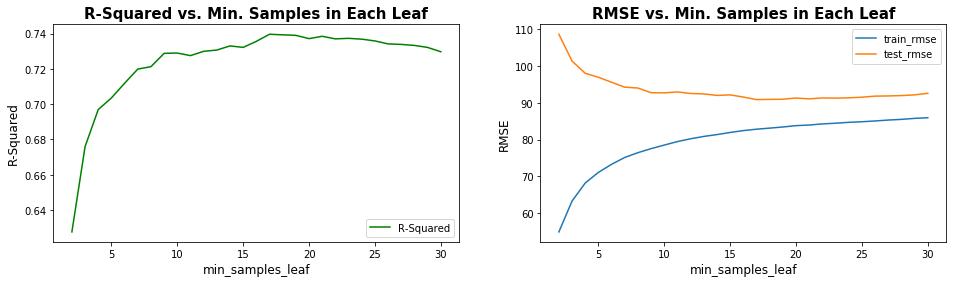

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

x = range(2,31)

# R-Squared
ax[0].plot(x, r2s, color="g", label="R-Squared")
ax[0].set_title("R-Squared vs. Min. Samples in Each Leaf", 
                fontdict={"fontsize":15, 
                          "fontweight":"bold"})
ax[0].set_xlabel("min_samples_leaf",
                 fontdict={"fontsize":12})
ax[0].set_ylabel("R-Squared",
                 fontdict={"fontsize":12})
ax[0].legend(loc=4)

# RMSE vs. Min. samples in each leaf
plt.plot(x, train_rmses, label="train_rmse")
plt.plot(x, test_rmses, label="test_rmse")

plt.xlabel("min_samples_leaf",
           fontdict={"fontsize":12})
plt.ylabel("RMSE",
           fontdict={"fontsize":12})
plt.title("RMSE vs. Min. Samples in Each Leaf",
          fontdict={"fontsize":15,
                    "fontweight":"bold"})

plt.legend()
plt.show()

### Results

| Model | Train RMSE | Test RMSE | R-Squared |
| :--- | --- | --- | --- |
| Linear Regression w/ 6 features | 133.07 | 130.87 | 0.46 |
| DTR w/ default parameters | 33.98 | 118.8 | 0.555 |
| **DTR w/ min_samples_leaf=17** | **82.82** | **90.87** | **0.74** |

Based on the results above, you can see the RMSE for the data starts to converge around 17 minimum samples. But the R-Squared gradually decreases as the minimum samples increase. Let's move forward with **17 samples in each leaf** in our model as it yields **a RMSE of 82.82 and 90.87** for the `train` and `test` respectively; and a **R-Squared of 0.74**.

Let's explore other parameters to see if we can capture more of the variation in our model (our model currently accounts for 73.93% of the variation in the data). 

In [17]:
def decision_tree_reg(data, features, target, max_d=None, min_s_leaf=2):
    
    df = data.copy()
    
    train = df.sample(frac=.8, random_state=1)
    test = df.drop(train.index)

    dtr = DecisionTreeRegressor(random_state=1,
                                max_depth=max_d,
                                min_samples_leaf=min_s_leaf)

    dtr.fit(train[features], train[target])
    dtr_train_pred = dtr.predict(train[features])
    dtr_train_mse = mean_squared_error(train[target], dtr_train_pred)
    dtr_train_rmse = np.sqrt(dtr_train_mse)

    dtr_test_pred = dtr.predict(test[features])
    dtr_test_mse = mean_squared_error(test[target], dtr_test_pred)
    dtr_test_rmse = np.sqrt(dtr_test_mse)
    dtr_score = dtr.score(test[features], test[target])

    print("Decision Tree Regression")
    print("Max Depth: {}".format(max_d))
    print("Min. Samples Leaf: {}".format(min_s_leaf))
    print("="*50)
    print("Train RMSE: {}".format(dtr_train_rmse))
    print("Test RMSE: {}".format(dtr_test_rmse))
    print("R2: {}".format(dtr_score))
    print("\n")
        
    return dtr_train_rmse, dtr_test_rmse, dtr_score

depth_train_rmse = []
depth_test_rmse = []
depth_r2 = []


for i in range(1, 21):
    train_rmse, test_rmse, r2 = decision_tree_reg(bike_rentals, features, "cnt", i, 17)
    depth_train_rmse.append(train_rmse)
    depth_test_rmse.append(test_rmse)
    depth_r2.append(r2)

Decision Tree Regression
Max Depth: 1
Min. Samples Leaf: 17
Train RMSE: 152.12820136619715
Test RMSE: 148.4804214900314
R2: 0.30469117585026473


Decision Tree Regression
Max Depth: 2
Min. Samples Leaf: 17
Train RMSE: 139.98027858198864
Test RMSE: 135.73585137094457
R2: 0.41892993800907075


Decision Tree Regression
Max Depth: 3
Min. Samples Leaf: 17
Train RMSE: 129.75638436924132
Test RMSE: 127.23384352438717
R2: 0.48944251088234636


Decision Tree Regression
Max Depth: 4
Min. Samples Leaf: 17
Train RMSE: 119.64051895268517
Test RMSE: 118.0573886609924
R2: 0.5604323701539935


Decision Tree Regression
Max Depth: 5
Min. Samples Leaf: 17
Train RMSE: 108.12434124451124
Test RMSE: 108.42177189666815
R2: 0.6292575132215932


Decision Tree Regression
Max Depth: 6
Min. Samples Leaf: 17
Train RMSE: 102.26553964219364
Test RMSE: 103.74195847551456
R2: 0.6605715486796295


Decision Tree Regression
Max Depth: 7
Min. Samples Leaf: 17
Train RMSE: 94.74937246373862
Test RMSE: 98.15573152177922
R2: 

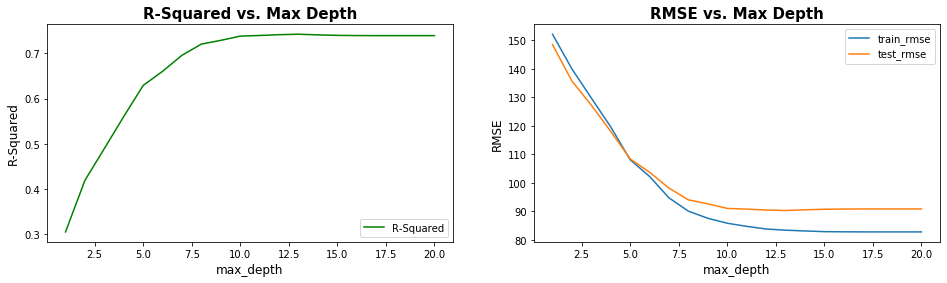

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

x = range(1,21)

# R-Squared
ax[0].plot(x, depth_r2, color="g", label="R-Squared")
ax[0].set_title("R-Squared vs. Max Depth", 
                fontdict={"fontsize":15, 
                          "fontweight":"bold"})
ax[0].set_xlabel("max_depth",
                 fontdict={"fontsize":12})
ax[0].set_ylabel("R-Squared",
                 fontdict={"fontsize":12})
ax[0].legend(loc=4)

# RMSE vs. Min. samples in each leaf
plt.plot(x, depth_train_rmse, label="train_rmse")
plt.plot(x, depth_test_rmse, label="test_rmse")

plt.xlabel("max_depth",
           fontdict={"fontsize":12})
plt.ylabel("RMSE",
           fontdict={"fontsize":12})
plt.title("RMSE vs. Max Depth",
          fontdict={"fontsize":15,
                    "fontweight":"bold"})

plt.legend()
plt.show()

### Results

| Model | Train RMSE | Test RMSE | R-Squared |
| :--- | --- | --- | --- |
| Linear Regression w/ 6 features | 133.07 | 130.87 | 0.46 |
| DTR w/ default parameters | 33.98 | 118.8 | 0.555 |
| DTR w/ min_samples_leaf=17 | 82.82 | 90.87 | 0.74 |
| **DTR w/ min_samples_leaf=17, max_depth=13** | **83.43** | **90.33** | **0.743** |

The next parameter we decided to tweak was `max_depth`. According to the results above, the RMSE and R-Squared values start to converge around the **`max_depth` = 13**. However this still produces very similar results of **RMSEs of 83.43 and 90.33** on `train` and `test` respectively; with a **R-Squared of 0.743**.

Since our decision tree seems to not be performing as well as we would have hoped, let's try a Random Forest Regression.

## Random Forest Regression

In [19]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regression(data, features, target, max_d=None, min_s_leaf=2):
    
    df = data.copy()
    
    train = df.sample(frac=.8, random_state=1)
    test = df.drop(train.index)
    
    rfr = RandomForestRegressor(random_state=1,
                                max_depth=max_d,
                                min_samples_leaf=min_s_leaf)
    
    rfr.fit(train[features], train[target])
    
    rfr_train_pred = rfr.predict(train[features])
    rfr_train_mse = mean_squared_error(train[target], rfr_train_pred)
    rfr_train_rmse = np.sqrt(rfr_train_mse)
    
    rfr_test_pred = rfr.predict(test[features])
    rfr_test_mse = mean_squared_error(test[target], rfr_test_pred)
    rfr_test_rmse = np.sqrt(rfr_test_mse)
    rfr_score = rfr.score(test[features], test[target])
    
    print("Random Forest Regression")
    print("Max Depth: {}".format(max_d))
    print("Min. Samples Leaf: {}".format(min_s_leaf))
    print("="*50)
    print("Train RMSE: {}".format(rfr_train_rmse))
    print("Test RMSE: {}".format(rfr_test_rmse))
    print("R2: {}".format(rfr_score))
    print("\n")
        
    
    return rfr_train_rmse, rfr_test_rmse, rfr_score



random_forest_regression(bike_rentals, features, "cnt")
    
    

Random Forest Regression
Max Depth: None
Min. Samples Leaf: 2
Train RMSE: 57.83169759041193
Test RMSE: 91.55227554900753
R2: 0.7356510168859084




(57.83169759041193, 91.55227554900753, 0.7356510168859084)

### Results

| Model | Train RMSE | Test RMSE | R-Squared |
| :--- | --- | --- | --- |
| Linear Regression w/ 6 features | 133.07 | 130.87 | 0.46 |
| DTR w/ default parameters | 33.98 | 118.8 | 0.555 |
| DTR w/ min_samples_leaf=17 | 82.82 | 90.87 | 0.74 |
| DTR w/ min_samples_leaf=17, max_depth=13 | 83.43 | 90.33 | 0.743 |
| **RF w/ default parameters** | **57.83** | **91.55** | **0.736** |

With the default parameters in the random forest regression, the model got worse as it overfit the data. Let's tweak some parameters.

In [20]:
for d in range(1,21):
    random_forest_regression(bike_rentals, features, "cnt", d)

# max_depth = 11

Random Forest Regression
Max Depth: 1
Min. Samples Leaf: 2
Train RMSE: 152.12826461047766
Test RMSE: 148.48419308365996
R2: 0.30465585192524935


Random Forest Regression
Max Depth: 2
Min. Samples Leaf: 2
Train RMSE: 139.4577893904491
Test RMSE: 135.17101448629512
R2: 0.42375588357032024


Random Forest Regression
Max Depth: 3
Min. Samples Leaf: 2
Train RMSE: 128.76817120910363
Test RMSE: 126.30458014962348
R2: 0.496873078045984


Random Forest Regression
Max Depth: 4
Min. Samples Leaf: 2
Train RMSE: 118.54737314403691
Test RMSE: 116.77885806832619
R2: 0.5699016208068937


Random Forest Regression
Max Depth: 5
Min. Samples Leaf: 2
Train RMSE: 106.65863037293927
Test RMSE: 106.94844773151563
R2: 0.6392649607273562


Random Forest Regression
Max Depth: 6
Min. Samples Leaf: 2
Train RMSE: 99.4611821638142
Test RMSE: 100.59790992177992
R2: 0.6808335206966115


Random Forest Regression
Max Depth: 7
Min. Samples Leaf: 2
Train RMSE: 92.43806228025095
Test RMSE: 95.15152509325519
R2: 0.71445742

In [21]:
# For the minimum sample in the leafs

rf_train_rmses = []
rf_test_rmses = []
rf_r2s = []
for s in range(2,101):
    tr, ts, r2 = random_forest_regression(bike_rentals, features, "cnt", max_d=11, min_s_leaf=s)
    
    rf_train_rmses.append(tr)
    rf_test_rmses.append(ts)
    rf_r2s.append(r2)
    
    
# min_samples_leaf = 6

Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 2
Train RMSE: 75.71150340420363
Test RMSE: 88.28931166720103
R2: 0.7541582608970956


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 3
Train RMSE: 76.683638078953
Test RMSE: 87.94898432877355
R2: 0.7560498921470675


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 4
Train RMSE: 77.54048788023393
Test RMSE: 87.85030269800039
R2: 0.7565970249897424


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 5
Train RMSE: 78.31799488956878
Test RMSE: 87.73878931123127
R2: 0.7572145632879546


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 6
Train RMSE: 79.02645360618583
Test RMSE: 87.71202892536105
R2: 0.7573626401242469


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 7
Train RMSE: 79.6757390765496
Test RMSE: 87.71848815583375
R2: 0.7573269025326044


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 8
Train RMSE: 80.20315893259337
Test RMSE: 87.75992758539638
R2: 0.75709756410479

Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 44
Train RMSE: 88.9145105206998
Test RMSE: 91.75109127269397
R2: 0.7345016451111378


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 45
Train RMSE: 89.03842849379325
Test RMSE: 91.83154705724533
R2: 0.734035814269599


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 46
Train RMSE: 89.15867561601621
Test RMSE: 91.9545739858376
R2: 0.733322711289834


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 47
Train RMSE: 89.30397766800691
Test RMSE: 92.06590726282913
R2: 0.7326765655101357


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 48
Train RMSE: 89.49329271656136
Test RMSE: 92.21870303283137
R2: 0.7317885107273147


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 49
Train RMSE: 89.65560572848565
Test RMSE: 92.36618540864377
R2: 0.7309299408918477


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 50
Train RMSE: 89.81274537434867
Test RMSE: 92.48849248936727
R2: 0.73021688

Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 86
Train RMSE: 93.64760511834871
Test RMSE: 95.49414756809038
R2: 0.7123973586549215


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 87
Train RMSE: 93.75106660619423
Test RMSE: 95.57433082544928
R2: 0.7119141751523159


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 88
Train RMSE: 93.88485528581083
Test RMSE: 95.65079464541095
R2: 0.7114530271806105


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 89
Train RMSE: 94.01114714208305
Test RMSE: 95.7459844815614
R2: 0.7108784285826125


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 90
Train RMSE: 94.07380043331709
Test RMSE: 95.79488978946453
R2: 0.710582997068315


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 91
Train RMSE: 94.15043245305944
Test RMSE: 95.86755594013326
R2: 0.7101437503370058


Random Forest Regression
Max Depth: 11
Min. Samples Leaf: 92
Train RMSE: 94.22713511715577
Test RMSE: 95.92057366452063
R2: 0.709823

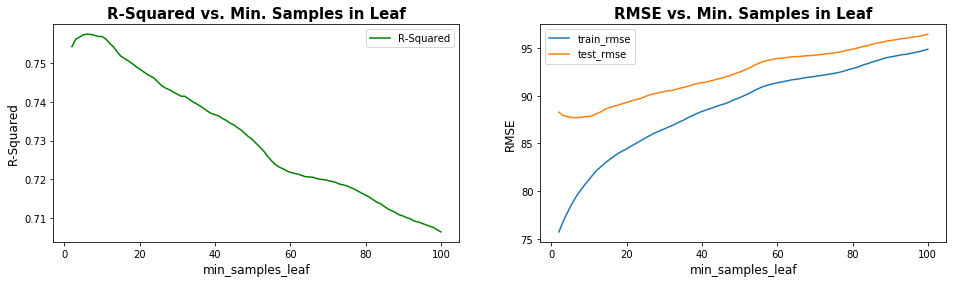

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

x = range(2,101)

# R-Squared
ax[0].plot(x, rf_r2s, color="g", label="R-Squared")
ax[0].set_title("R-Squared vs. Min. Samples in Leaf", 
                fontdict={"fontsize":15, 
                          "fontweight":"bold"})
ax[0].set_xlabel("min_samples_leaf",
                 fontdict={"fontsize":12})
ax[0].set_ylabel("R-Squared",
                 fontdict={"fontsize":12})
ax[0].legend(loc=1)

# RMSE vs. Min. samples in each leaf
plt.plot(x, rf_train_rmses, label="train_rmse")
plt.plot(x, rf_test_rmses, label="test_rmse")

plt.xlabel("min_samples_leaf",
           fontdict={"fontsize":12})
plt.ylabel("RMSE",
           fontdict={"fontsize":12})
plt.title("RMSE vs. Min. Samples in Leaf",
          fontdict={"fontsize":15,
                    "fontweight":"bold"})

plt.legend()
plt.show()

### Results

| Model | Train RMSE | Test RMSE | R-Squared |
| :--- | --- | --- | --- |
| Linear Regression w/ 6 features | 133.07 | 130.87 | 0.46 |
| DTR w/ default parameters | 33.98 | 118.8 | 0.555 |
| DTR w/ min_samples_leaf=17 | 82.82 | 90.87 | 0.74 |
| DTR w/ min_samples_leaf=17, max_depth=13 | 83.43 | 90.33 | 0.743 |
| RF w/ default parameters | 57.83 | 91.55 | 0.736 |
| **RF w/ min_samples_leaf=6, max_depth=11** | **79.03** | **87.71** | **0.757** |

With this random forest regression, we were able to reduce the **RMSE to 79.03 and 87.71** for `train` and `test` respectively, and a **R-Squared of 0.757**; with **`min_samples_leaf` = 6 and `max_depth` = 11**.

As you can tell by the visuals above, the R-Squared is negatively correlated with the minimum samples in a leaf,  while RMSE is positively correlated. Depending on our goal of the model, whether to find the exact features that fully represent the `cnt` column or be able to make accurate predictions with minimal overfitting, we can choose a certain `min_samples_leaf`. 

## Conclusion

With all the models we created above to predict the total number of bike rentals in a given hour, we found that the season, year, hour of day, temperature during the hour, humidity of the hour, and the time of day yielded the the best predictions for our linear regression model. We found that the random forest regression yielded the best predictions (based on RMSE and R-Squared) out of all the models, as expected.

## Next Steps

With these results, we can use the random forest regression model to maybe better prepare shift scheduling on busier hours and/or have more available bike rentals during a specific time period.

**Thank you for reading through this project! Open to any feedback/comments :)**